In [170]:
%matplotlib inline

In [171]:
import matplotlib.pyplot as plt
import numpy as np
import GPy

In [172]:
GPy.plotting.change_plotting_library('matplotlib')

In [173]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_mldata
from IPython.display import display

## Data preparation

In [174]:
data = fetch_mldata('mauna-loa-atmospheric-co2').data
X = data[:, [1]]
y = data[:, 0]

In [175]:
y = y.reshape(-1,1)

In [176]:
print(X.shape)
print(y.shape)

(468, 1)
(468, 1)


In [177]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

In [178]:
print(X_train.shape)
print(y_train.shape)

(313, 1)
(313, 1)


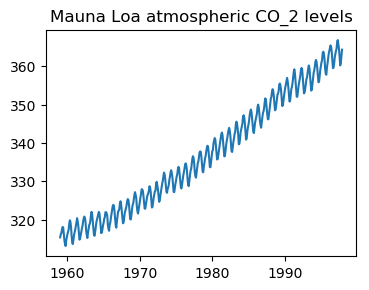

In [228]:
fig,ax = plt.subplots(1,1, figsize=(4, 3), dpi=100)
ax.plot(X,y)
plt.title("Mauna Loa atmospheric CO_2 levels")

## GP regression

In [192]:
# rbf kernel, for long term trend
k11 = GPy.kern.RBF(1, np.exp(4.), np.exp(4.)) 
k12 = GPy.kern.Linear(1)
k1 = k11 * k12

# periodic kernel, for seasonal component
k21 = GPy.kern.PeriodicExponential(1, variance=np.exp(1.), lengthscale=1., period=1.)
k22 = GPy.kern.RBF(1, np.exp(4.), 1.) 
k2 = k21 * k22 

# rational quadratic kernel, for fluctuations with different length scales
k31 = GPy.kern.RatQuad(1, variance=1., lengthscale=1., power=np.exp(-1.))
k32 = GPy.kern.RBF(1, np.exp(4.), 1.) 
k3 = k31 * k32

k = k1 + k2 + k3

In [195]:
m = GPy.models.GPRegression(X_train,y_train,k)

In [196]:
# meanLinear = GPy.mappings.Linear(1,1)
# meanLinear.update_gradients()
# meanConst = GPy.mappings.Constant(1, 1, value=-2360)
# mean = GPy.mappings.Additive(meanLinear, meanConst)
# m = GPy.models.GPRegression(X,y,k,mean_function=mean)

In [197]:
m.optimize_restarts(num_restarts = 5)

Optimization restart 1/5, f = 222.35552231495134
Optimization restart 2/5, f = 622.8124604577914
Optimization restart 3/5, f = 296.67546091078145
Optimization restart 4/5, f = 324.3577900615095


/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/GPy/kern/src/stationary.py:628: RuntimeWarning:

overflow encountered in square

/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/GPy/kern/src/stationary.py:633: RuntimeWarning:

overflow encountered in square

/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/GPy/kern/src/stationary.py:640: RuntimeWarning:

overflow encountered in square

/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/GPy/kern/src/stationary.py:642: RuntimeWarning:

invalid value encountered in multiply



Optimization restart 5/5, f = 111.13771027402953


In [217]:
display(m)

GP_regression.,value,constraints,priors
sum.mul.rbf.variance,139.26089160801035,+ve,
sum.mul.rbf.lengthscale,240.41370107847985,+ve,
sum.mul.linear.variances,187.13238217460437,+ve,
sum.mul_1.periodic_exponential.variance,60.76280717072997,+ve,
sum.mul_1.periodic_exponential.lengthscale,31.484016354414226,+ve,
sum.mul_1.periodic_exponential.period,0.9997749503796199,+ve,
sum.mul_1.rbf.variance,38.734970454323026,+ve,
sum.mul_1.rbf.lengthscale,51.82212466497748,+ve,
sum.mul_2.RatQuad.variance,0.3217480481147556,+ve,
sum.mul_2.RatQuad.lengthscale,0.29072639624220664,+ve,


In [205]:
def addConfidenceBounds(ax,x,mu,s):
    ax.fill_between(np.squeeze(x), np.squeeze(mu-2*s), np.squeeze(mu+2*s), facecolor='grey', alpha=0.2)

def removeConfidenceBounds(ax):
    for coll in (ax.collections): ax.collections.remove(coll)

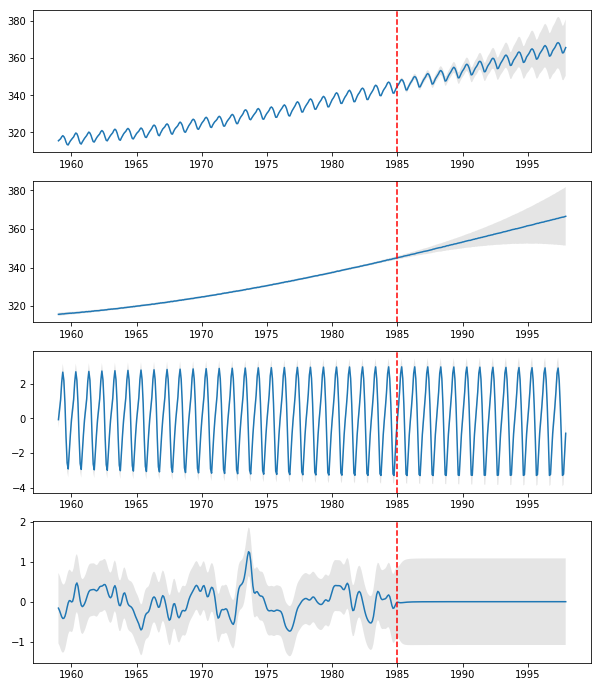

In [216]:
kernel_list = [k]+ k.parts
fig, axs = plt.subplots(len(kernel_list),1, figsize=(10, 12), facecolor='w', edgecolor='k')  
axs = axs.ravel()
x_end_training = X_train[-1]

for i,ker in enumerate(kernel_list):
    mu,s2 = m.predict(X,kern = ker)
    s = np.sqrt(s2)
    axs[i].plot(X,mu)
    addConfidenceBounds(axs[i],X,mu,s)
    axs[i].axvline(x_end_training,color='r', linestyle="dashed")

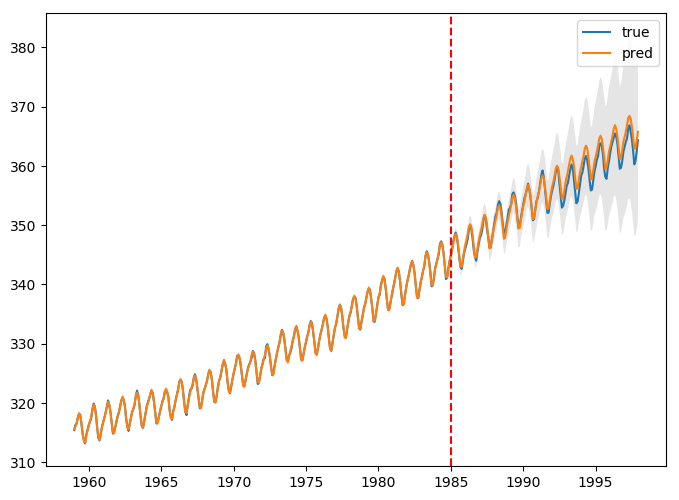

In [226]:
fig,ax = plt.subplots(1,1, figsize=(8, 6), dpi=100)
y_mu,y_s2 = m.predict(X)
y_s = np.sqrt(y_s2)
ax.plot(X,y,label="true")
ax.plot(X,y_mu,label="pred")
addConfidenceBounds(ax,X,y_mu,y_s)
ax.axvline(x_end_training,color='r', linestyle="dashed")
plt.legend()

In [201]:
np.mean(m.log_predictive_density(X_test, y_test))

-1.8082347358138893

In [202]:
np.mean(m.log_predictive_density(X_train, y_train))

0.26616206967873884